In [97]:
# import sys
# !{sys.executable} -m pip install tensorflow

In [250]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [251]:
df = pd.read_csv('./../../labeledTweets/allLabeledTweets.csv')
df = df[['id', 'message', 'label']]
df.head()

,id,message,label
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0


In [252]:
df['label'].value_counts()

0    968
2    647
1    410
Name: label, dtype: int64

In [253]:
newLine ="\\n|\\r"
df['clean_message'] = df['message'].str.replace(newLine,' ',regex=True).str.strip()
df.head()

,id,message,label,clean_message
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: #airBaltic “potenciālie pircēji ir no...
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...


# Train, validate split

In [254]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [255]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message  clean_message
label data_type                             
0     train      823      823            823
      val        145      145            145
1     train      348      348            348
      val         62       62             62
2     train      550      550            550
      val         97       97             97

In [256]:
df.head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: #airBaltic “potenciālie pircēji ir no...,val
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,train


In [257]:
# df.to_csv('./tweets_base.csv', index=False)

# df = pd.read_csv('./../labeledTweets/p_n_n_and_labeled_corpus_train_val.csv')

## Balance training data

In [258]:
df[df.data_type=='train']['label'].value_counts()

0    823
2    550
1    348
Name: label, dtype: int64

In [259]:
df[df.data_type=='train'].head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,train
5,1481060,airBaltic uzsāks lidojumus uz Sočiem un Kaļiņi...,0,airBaltic uzsāks lidojumus uz Sočiem un Kaļiņi...,train


In [260]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_1.shape[0], random_state=42)
df_2_downsampled = df_2.sample(df_1.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_2_downsampled, df_1])

df_train['label'].value_counts()

0    348
1    348
2    348
Name: label, dtype: int64

In [261]:
df_train.head()

,clean_message,label
1526,"@laura_freiberga Sveiki! Lūdzu, atsūti DM savu...",0
567,Tiešraide jau pēc 30 minūtēm! @hsrigahockey -...,0
260,"ES ATVAINOJOS, VAI IR KĀDS IZDEVĪGĀKS PAR LATV...",0
560,Tiešraide jau pēc 30 minūtēm! @hsrigahockey -...,0
777,SEB ievieš Latvijā pirmo indeksu plānu pensiju...,0


In [262]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
700,Šodien norisinās SEB MTB maratons. Finišs @val...,0
1911,@digidigidong Sveiks! Tas neattiecas uz mūsu e...,1
505,"@BriedeBriede @kungavsand_ Starpcitu, Maxima t...",1
1471,Taisnība ir uzvarējusi! Martins Dukurs kļūst p...,1
1537,@houdshwick Спасибо за мнение.^el,0


# Tokenizer "bert-base-multilingual-cased"

In [263]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

### Find max length for tokenizer

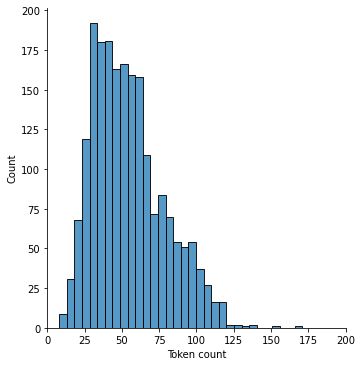

In [264]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

In [265]:
max_length = 175

### Encode messages

In [266]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\aligo\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [267]:
len(dataset_train), len(dataset_val)

(1044, 304)

In [268]:
# torch.save(dataset_train, './datasetsLowercase/dataset_train.pt')
# torch.save(dataset_val, './datasetsLowercase/dataset_val.pt')

In [269]:
# dataset_train = torch.load('./datasetsLowercase/dataset_train.pt')
# dataset_val = torch.load('./datasetsLowercase/dataset_val.pt')

In [270]:
# len(dataset_train), len(dataset_val)

# Model "bert-base-multilingual-cased"

In [271]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [272]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [273]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [274]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [275]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [276]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [277]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Evaluate untrained model

In [278]:
_, predictions, true_vals = evaluate(dataloader_validation)

from sklearn.metrics import classification_report, confusion_matrix

preds_flat = np.argmax(predictions, axis=1).flatten()

print(classification_report(true_vals, preds_flat))
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

              precision    recall  f1-score   support

           0       0.42      0.17      0.24       145
           1       0.20      0.76      0.32        62
           2       0.08      0.01      0.02        97

    accuracy                           0.24       304
   macro avg       0.23      0.31      0.19       304
weighted avg       0.27      0.24      0.19       304



predicted                  
                  neutral positive negative
actual neutral         25      111        9
       positive        13       47        2
       negative        22       74        1

# Train

In [245]:
# torch.cuda.device_count()

In [246]:
# torch.cuda.memory_allocated(0)

In [247]:
# torch.cuda.memory_reserved(0)

In [248]:
# torch.cuda.empty_cache()
# total_memory = torch.cuda.get_device_properties(0).total_memory
# torch.cuda.set_per_process_memory_fraction(0.5, 0)
# application = int(total_memory * 0.499) - torch.cuda.max_memory_reserved()
# tmp_tensor = torch.empty(application, dtype=torch.int8, device='cuda')
# del tmp_tensor
# torch.cuda.empty_cache()

In [279]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsBase/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0992802309267449
Validation loss: 1.073461902141571
F1 Score (Weighted): 0.5070578805339082
              precision    recall  f1-score   support

           0       0.56      0.86      0.68       145
           1       0.50      0.24      0.33        62
           2       0.52      0.28      0.36        97

    accuracy                           0.55       304
   macro avg       0.53      0.46      0.46       304
weighted avg       0.54      0.55      0.51       304



Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.0668037949186382
Validation loss: 1.040076345205307
F1 Score (Weighted): 0.43975472799929777
              precision    recall  f1-score   support

           0       0.68      0.54      0.60       145
           1       0.23      0.58      0.33        62
           2       0.55      0.18      0.27        97

    accuracy                           0.43       304
   macro avg       0.48      0.43      0.40       304
weighted avg       0.54      0.43      0.44       304



Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9999582370122274
Validation loss: 0.9337622165679932
F1 Score (Weighted): 0.5962782518610802
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       145
           1       0.47      0.34      0.39        62
           2       0.58      0.57      0.57        97

    accuracy                           0.61       304
   macro avg       0.57      0.55      0.55       304
weighted avg       0.59      0.61      0.60       304



Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.9240959232503717
Validation loss: 0.8938226163387298
F1 Score (Weighted): 0.6292943996435486
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       145
           1       0.52      0.35      0.42        62
           2       0.64      0.58      0.61        97

    accuracy                           0.64       304
   macro avg       0.61      0.58      0.59       304
weighted avg       0.63      0.64      0.63       304



Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.8979724230188312
Validation loss: 0.9116788804531097
F1 Score (Weighted): 0.6100764005644496
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       145
           1       0.44      0.50      0.47        62
           2       0.63      0.56      0.59        97

    accuracy                           0.61       304
   macro avg       0.58      0.58      0.58       304
weighted avg       0.61      0.61      0.61       304



# Evaluate

In [210]:
model.load_state_dict(torch.load('modelsBase/finetuned_BERT_epoch_4.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
print(classification_report(true_vals, preds_flat))

In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])